In [1]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
# tf.config.run_functions_eagerly(True)
from PIL import Image
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import os, random

In [2]:
# # Forbidden GPUs
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# set gpus memory used by growth
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print("find gpus:",gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

find gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


![stru](../docs/DUF/net-stru.png)

3, 360, 640, 3 -> 1,360,640,256

-> R_t: 1, 360, 640, 48

-> F_t: 1, 1, 360, 640, 25, 16

r = 2

In [3]:
# class ResBlock(tf.keras.layers.Layer):
#     def __init__(self):
#         super(ResBlock, self).__init__()
#         print("ResBlock inited.")

#     def call(self, inputs):
#         #x = tf.nn.batch_normalization(inputs)
#         x = tf.keras.layers.Conv2D(64,1,padding='same',activation='relu')(inputs)
#         #x = tf.nn.batch_normalization(x)
#         x = tf.keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
#         # print("ResBlock Finished.")
#         return x

In [4]:
batch = 1
ind = 3
inh = 90
inw = 195
inc = 3
uf = 4
stp = [[0,0], [1,1], [1,1], [1,1], [0,0]]
sp = [[0,0], [0,0], [1,1], [1,1], [0,0]]

In [5]:
class DUF_Conv(tf.keras.models.Model):
    def __init__(self,uf):
        # 调用父类__init__()方法
        super(DUF_Conv, self).__init__()
        self.conv3d_1 = tf.keras.layers.Conv3D(64, 3, strides=1, padding='valid', activation='relu', name="conv1")
        self.rconv1a = tf.keras.layers.Conv3D(64, 1, strides=(1,1,1), padding='valid', activation='relu', name="rconv1a")
        self.rconv1b = tf.keras.layers.Conv3D(32, 3, strides=1, padding='valid', activation='relu', name="rconv1b")
        self.rconv2a = tf.keras.layers.Conv3D(96, 1, strides=(1,1,1), padding='valid', activation='relu', name="rconv2a")
        self.rconv2b = tf.keras.layers.Conv3D(32, 3, strides=1, padding='valid', activation='relu', name="rconv2b")
        self.rconv3a = tf.keras.layers.Conv3D(128, 1, strides=(1,1,1), padding='valid', activation='relu', name="rconv3a")
        self.rconv3b = tf.keras.layers.Conv3D(32, 3, strides=1, padding='valid', activation='relu', name="rconv3b")
        self.rconv4a = tf.keras.layers.Conv3D(160, 1, strides=(1,1,1), padding='valid', activation='relu', name="rconv4a")
        self.rconv4b = tf.keras.layers.Conv3D(32, 3, strides=1, padding='valid', activation='relu', name="rconv4b")
        self.rconv5a = tf.keras.layers.Conv3D(192, 1, strides=(1,1,1), padding='valid', activation='relu', name="rconv5a")
        self.rconv5b = tf.keras.layers.Conv3D(32, 3, strides=1, padding='valid', activation='relu', name="rconv5b")
        self.rconv6a = tf.keras.layers.Conv3D(224, 1, strides=(1,1,1), padding='valid', activation='relu', name="rconv6a")
        self.rconv6b = tf.keras.layers.Conv3D(32, 3, strides=1, padding='valid', activation='relu', name="rconv6b")
        self.bn1a = tf.keras.layers.BatchNormalization()
        self.bn1b = tf.keras.layers.BatchNormalization()
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.bn3a = tf.keras.layers.BatchNormalization()
        self.bn3b = tf.keras.layers.BatchNormalization()
        self.bn4a = tf.keras.layers.BatchNormalization()
        self.bn4b = tf.keras.layers.BatchNormalization()
        self.bn5a = tf.keras.layers.BatchNormalization()
        self.bn5b = tf.keras.layers.BatchNormalization()
        self.bn6a = tf.keras.layers.BatchNormalization()
        self.bn6b = tf.keras.layers.BatchNormalization()
        # ------
        #self.fbn1 = tf.keras.layers.BatchNormalization()
        self.conv3d_s = tf.keras.layers.Conv3D(256,3,strides=(1,1,1),padding="valid", activation='relu', name="conv3d_s")
        
        self.rconv1 = tf.keras.layers.Conv3D(256,1,strides=(1,1,1),padding="valid", activation='relu', name="rconv1")
        self.rconv2 = tf.keras.layers.Conv3D(3*uf*uf,1,strides=(1,1,1),padding="valid", activation='relu', name="rconv2")
        
        self.fconv1 = tf.keras.layers.Conv3D(512,1,strides=(1,1,1),padding="valid", activation='relu', name="fconv1")
        self.fconv2 = tf.keras.layers.Conv3D(1*5*5*uf*uf,1,strides=(1,1,1),padding="valid", activation='relu', name="fconv2")
        
        self.uf = uf
        #print("Model inited.")

    def call(self, inputs):
        #print("inputs: ",inputs)
        x = self.conv3d_1(tf.pad(inputs, paddings=sp, mode='CONSTANT', name="padding"))
        #print("x:",x)
        
        t = self.bn1a(x)
        t = self.rconv1a(t)
        t = self.bn1b(t)
        t = self.rconv1b(tf.pad(t, paddings=stp, mode='CONSTANT', name="padding"))
        x = tf.concat([x, t], 4)
        #print("x:",x)
        t = self.bn2a(x)
        t = self.rconv2a(t)
        t = self.bn2b(t)
        t = self.rconv2b(tf.pad(t, paddings=stp, mode='CONSTANT', name="padding"))
        x = tf.concat([x, t], 4)
        #print("x:",x)
        t = self.bn3a(x)
        t = self.rconv3a(t)
        t = self.bn3b(t)
        t = self.rconv3b(tf.pad(t, paddings=stp, mode='CONSTANT', name="padding"))
        x = tf.concat([x, t], 4)
        #print("x:",x)
        t = self.bn4a(x)
        t = self.rconv4a(t)
        t = self.bn4b(t)
        t = self.rconv4b(tf.pad(t, paddings=stp, mode='CONSTANT', name="padding"))
        x = tf.concat([x, t], 4)
        #print("x:",x)
        t = self.bn5a(x)
        t = self.rconv5a(t)
        t = self.bn5b(t)
        t = self.rconv5b(tf.pad(t, paddings=stp, mode='CONSTANT', name="padding"))
        x = tf.concat([x, t], 4)
        #print("x:",x)
        t = self.bn6a(x)
        t = self.rconv6a(t)
        t = self.bn6b(t)
        t = self.rconv6b(tf.pad(t, paddings=stp, mode='CONSTANT', name="padding"))
        x = tf.concat([x, t], 4)
        #print("x:",x)
        #x = self.fbn1(x)
        x = self.conv3d_s(tf.pad(t, paddings=stp, mode='CONSTANT', name="padding"))
        x = tf.nn.relu(x)
        #print(x)
        
        r = self.rconv1(x)
        r = self.rconv2(r)
        #print(r)
        
        f = self.fconv1(x)
        f = self.fconv2(f)
        #print(f)
        
        ds_f = tf.shape(f)
        f = tf.reshape(f, [ds_f[0], ds_f[1], ds_f[2], ds_f[3], 25, self.uf*self.uf])
        f = tf.nn.softmax(f, axis=4)
        #print(f)

        return f,r

In [6]:
def DynFilter3D(x, F, filter_size):
    '''
    3D Dynamic filtering
    input x: (b, t, h, w)
          F: (b, h, w, tower_depth, output_depth)
          filter_shape (ft, fh, fw)
    '''
    # make tower
    filter_localexpand_np = np.reshape(np.eye(np.prod(filter_size), np.prod(filter_size)), (filter_size[1], filter_size[2], filter_size[0], np.prod(filter_size)))
    filter_localexpand = tf.Variable(filter_localexpand_np, trainable=False, dtype='float32',name='filter_localexpand') 
    x = tf.transpose(x, perm=[0,2,3,1])
    x_localexpand = tf.nn.conv2d(x, filter_localexpand, [1,1,1,1], 'SAME') # b, h, w, 1*5*5
    x_localexpand = tf.expand_dims(x_localexpand, axis=3)  # b, h, w, 1, 1*5*5
    x = tf.matmul(x_localexpand, F) # b, h, w, 1, R*R
    x = tf.squeeze(x, axis=3) # b, h, w, R*R
    return x

In [7]:
def depth_to_space_3D(x, block_size):
    ds_x = tf.shape(x)
    x = tf.reshape(x, [ds_x[0]*ds_x[1], ds_x[2], ds_x[3], ds_x[4]])
    
    y = tf.compat.v1.depth_to_space(x, block_size)
    
    ds_y = tf.shape(y)
    x = tf.reshape(y, [ds_x[0], ds_x[1], ds_y[1], ds_y[2], ds_y[3]])
    return x

In [8]:
class DUF(tf.keras.models.Model):
    def __init__(self,uf,T_in):
        # 调用父类__init__()方法
        super(DUF, self).__init__()
        self.duf_conv = DUF_Conv(uf=uf)
        self.T_in = T_in
        self.uf = uf
        #print("Model inited.")

    def call(self, inputs):
        Fx, Rx = self.duf_conv(inputs)
        #print("Fx: ",Fx)
        #print("Rx: ",Rx)
        x_c = []
        for c in range(3):
            t = DynFilter3D(inputs[:,self.T_in//2:self.T_in//2+1,:,:,c], Fx[:,0,:,:,:,:], [1,5,5]) # [B,H,W,R*R]
            t = tf.compat.v1.depth_to_space(t, self.uf) # [B,H*R,W*R,1]
            x_c += [t]
        x = tf.concat(x_c, axis=3)   # [B,H*R,W*R,3]
        x = tf.expand_dims(x, axis=1)
        Rx = depth_to_space_3D(Rx, self.uf)   # [B,1,H*R,W*R,3]
        x += Rx
        x = tf.squeeze(x, axis=1)
        #print("Out: ",x)
        return x

In [9]:
duf = DUF(uf,ind)
duf.build(input_shape=(batch,ind,inh,inw,inc))
print(duf.summary())

Model: "duf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
duf__conv (DUF_Conv)         multiple                  1538400   
Total params: 1,538,400
Trainable params: 1,534,944
Non-trainable params: 3,456
_________________________________________________________________
None


In [10]:
def Huber(y_true, y_pred, delta=0.1, axis=None):
    abs_error = tf.abs(y_pred - y_true)
    quadratic = tf.minimum(abs_error, delta)
    # The following expression is the same in value as
    # tf.maximum(abs_error - delta, 0), but importantly the gradient for the
    # expression when abs_error == delta is 0 (for tf.maximum it would be 1).
    # This is necessary to avoid doubling the gradient, since there is already a
    # nonzero contribution to the gradient from the quadratic term.
    linear = (abs_error - quadratic)
    losses = 0.5 * quadratic**2 + delta * linear
    return tf.reduce_mean(losses, axis=axis)

In [11]:
duf.compile(optimizer='adam',
              loss=Huber,
              metrics=['accuracy'])

In [12]:
def generator(inpath, outpath, batch_size=1, reshuffle_each_iteration=True, besides=2):
    # read and sort train data from dir
    x_train_lr_list = os.listdir(inpath)
    x_train_lr_list.sort(key=lambda x:int(x[5:-4]))#倒着数第四位'.'为分界线，按照‘.’左边的数字从小到大排序
    x_train_lr_list = [os.path.join(inpath,c) for c in x_train_lr_list]
    y_train_list = os.listdir(outpath)
    y_train_list.sort(key=lambda x:int(x[5:-4]))
    y_train_list = [os.path.join(outpath,c) for c in y_train_list]
    #i = 0
    while True:
        middle = random.randint(besides,len(y_train_list)-besides)
        x_train_lr, y_train = loadimgs_from_paths(
            x_train_lr_list[middle-besides:middle+besides+1], y_train_list[middle:middle+1])
        #print(" ",middle-besides,middle+besides+1)
        x_train_lr = x_train_lr[np.newaxis, :]
        #print(np.shape(x_train_lr),np.shape(y_train))
        yield np.float32(x_train_lr/255), np.float32(y_train/255)
        #i = (i+1) % (len(x_train_lr_list) // batch_size)
        # print(len(x_train_lr_list) // batch_size)
#         if reshuffle_each_iteration:
#             if i == 0:
#                 paths = list(zip(x_train_lr_list, y_train_list))
#                 random.shuffle(paths)
#                 x_train_lr_list, y_train_list = zip(*paths)

In [13]:
history = duf.fit(generator("../data/cut_data4x","../data/cut_data",batch,besides=ind//2),steps_per_epoch=10, epochs=50, verbose=1)

Epoch 1/50
10/10 [==============================] - 1s 122ms/step - loss: 0.0025 - accuracy: 0.8780
Epoch 2/50
10/10 [==============================] - 1s 121ms/step - loss: 0.0023 - accuracy: 0.9192
Epoch 3/50
10/10 [==============================] - 1s 120ms/step - loss: 0.0015 - accuracy: 0.9397
Epoch 4/50
10/10 [==============================] - 1s 121ms/step - loss: 0.0017 - accuracy: 0.9429
Epoch 5/50
10/10 [==============================] - 1s 120ms/step - loss: 0.0011 - accuracy: 0.9545
Epoch 6/50
10/10 [==============================] - 1s 121ms/step - loss: 0.0011 - accuracy: 0.9588
Epoch 7/50
10/10 [==============================] - 1s 124ms/step - loss: 0.0012 - accuracy: 0.9584
Epoch 8/50
10/10 [==============================] - 1s 121ms/step - loss: 9.8672e-04 - accuracy: 0.9677
Epoch 9/50
10/10 [==============================] - 1s 121ms/step - loss: 0.0012 - accuracy: 0.9554
Epoch 10/50
10/10 [==============================] - 1s 121ms/step - loss: 0.0010 - accuracy: 0.

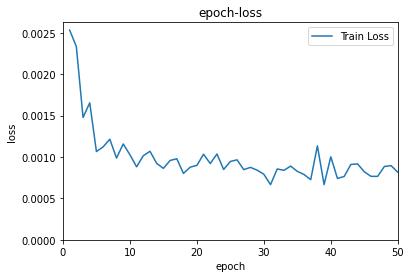

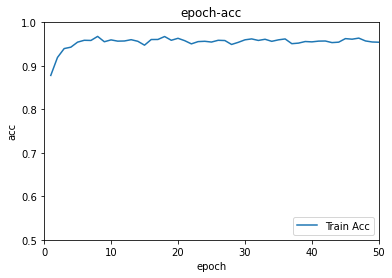

In [14]:
# Visualization
epochs = 50
l = np.array(history.history['loss'])
a = np.array(history.history['accuracy'])
step = np.linspace(1,epochs,epochs)
plt.plot(step,l,label="Train Loss")
plt.legend(loc='upper right')
plt.title('epoch-loss')
plt.xlim((0, epochs))
plt.gca().set_ylim(bottom=0)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('./static/train-loss.png', bbox_inches='tight')
plt.show()
plt.plot(step,a,label="Train Acc")
plt.legend(loc='lower right')
plt.title('epoch-acc')
plt.xlim((0, epochs))
plt.ylim((0.5, 1))
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig('./static/train-acc.png', bbox_inches='tight')
plt.show()

In [15]:
duf.save_weights("./model/DUF")